# graph_05_06_02_w

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/measurements/noise_model_cdr/master_thesis_qaoa'))

In [2]:
import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer

from helpers import *
from shared.QiskitMaxcut import *
from shared.graph_helper import *

In [3]:
%load_ext autoreload
%autoreload 2

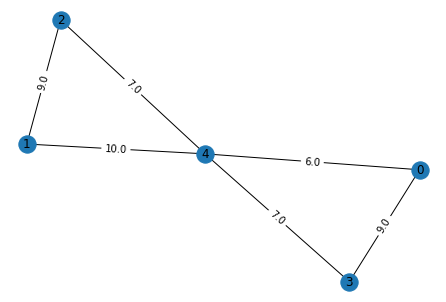

In [67]:
# ---- Define graph and MaxCut ----
#filename = "graph_3_reg_04_06_01.txt"#"graph_05_06_02_w.txt"
filename = "graph_05_06_02_w.txt"
graph = load_nx_graph_from(f"../data/{filename}")
opt_max_cut = -get_max_cut(graph.name)
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

### Goemans Williamson Solution

In [5]:
optimizer = GoemansWilliamsonOptimizer(5)
result = optimizer.solve(max_cut_qubo)
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

optimal function value: 4.0
optimal value: [0 1 0 1]
status: SUCCESS
0100: value: -3.000, probability: 33.3%
0111: value: -3.000, probability: 33.3%
0101: value: -4.000, probability: 33.3%
Expectation Value: -3.333333333333333
Highest Exp.Value: -3 with 66.667 %
Lowest Exp.Value: -4 with 33.333 %
Highest Probability: -3 with 66.667 %
Ratio r: 0.33333333333333304
Approiximation ratio: 0.8333333333333333
MSE: 0.2777777777777779
RMSE: 0.52704627669473


## Parameters

In [6]:
BACKEND, EVAL_NUM, MAX_ITER, MAX_P, SHOTS, initial_points = load_configs(graph.name)
display_configs()
all_results = {}

Backend = Simulator_Noise_Model
EVAL_NUM = 50
MAX_ITER = 0
MAX_P = 4
SHOTS = 1024
Initial_Points = [array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


## QAOA

In [7]:
from helpers.qaoa_helper import *

In [8]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2018, 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

""" The Quantum Approximate Optimization Algorithm with CDR. """

import mitiq
from shared.cdr.mitiq_cdr import execute_with_cdr
from mitiq.zne import mitigate_executor
from functools import partial
import cirq.circuits.circuit

from typing import Optional, List, Callable, Union, Dict, Tuple
import logging
import warnings
from time import time
import numpy as np

from qiskit import Aer
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.providers import BaseBackend
from qiskit.providers import Backend
from qiskit.opflow import (
    OperatorBase,
    ExpectationBase,
    ExpectationFactory,
    StateFn,
    CircuitStateFn,
    ListOp,
    I,
    CircuitSampler,
)
from qiskit.opflow.gradients import GradientBase
from qiskit.utils.validation import validate_min
from qiskit.utils.backend_utils import is_aer_provider
from qiskit.utils.deprecation import deprecate_function
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import Optimizer, SLSQP
from qiskit.algorithms.variational_algorithm import VariationalAlgorithm, VariationalResult
from qiskit.algorithms import MinimumEigensolver, MinimumEigensolverResult
from qiskit.algorithms.exceptions import AlgorithmError

from qiskit.algorithms.minimum_eigen_solvers.vqe import (
    VQE,
    VQEResult,
    _validate_initial_point,
    _validate_bounds
)

import sys
sys.path.append("..")
sys.path.append("../..")
from shared.gem.gem_postprocess import format_counts

logger = logging.getLogger(__name__)



from typing import List, Callable, Optional, Union
import numpy as np

from qiskit.algorithms.optimizers import Optimizer
from qiskit.circuit import QuantumCircuit
from qiskit.opflow import OperatorBase, ExpectationBase
from qiskit.opflow.gradients import GradientBase
from qiskit.providers import Backend
from qiskit.providers import BaseBackend
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.utils.validation import validate_min
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz

from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOA

class CDR_QAOA(QAOA):
    
    def sample_bitstrings_simulator(self, circuit, shots: int = 1024) -> Dict[int, int]:
        # Use Aer's qasm_simulator
        if type(circuit) == cirq.circuits.circuit.Circuit:
            circuit = mitiq.interface.mitiq_qiskit.conversions.to_qiskit(circuit)
            circuit.measure_all()
        backend_sim = Aer.get_backend('qasm_simulator')
        qi = QuantumInstance(backend=backend_sim, shots=self._quantum_instance._run_config.shots)
        result = qi.execute(circuit)

        counts = result.get_counts()
        formatted_counts = format_counts(counts, result.results[0].header)
        int_counts = {}
        for key in formatted_counts.keys():
            int_counts[int(key.replace(' ',''),2)] = formatted_counts[key]
            
        return int_counts
    
    
    def sample_bitstrings(self, circuits, shots: int = 1024) -> Dict[int, int]:
        
        qiskit_circuits = []
        for circuit in circuits:
        
            # convert cirq.circuit to qiskit-circuit 
            if type(circuit) == cirq.circuits.circuit.Circuit:
                circuit = mitiq.interface.mitiq_qiskit.conversions.to_qiskit(circuit)
            circuit.measure_all()
            qiskit_circuits.append(circuit)
        
        result = self._quantum_instance.execute(qiskit_circuits)
        circuit_int_counts = []
        
        for i in range(0, len(qiskit_circuits)):
            
            counts = result.results[i].data.counts.copy()
            formatted_counts = format_counts(counts, result.results[i].header)
            int_counts = {}
            for key in formatted_counts.keys():
                int_counts[int(key.replace(' ',''),2)] = formatted_counts[key]

            circuit_int_counts.append(int_counts.copy())
          
        return circuit_int_counts
    
    
    def get_energy_evaluation(
        self,
        operator: OperatorBase,
        return_expectation: bool = False,
    ) -> Callable[[np.ndarray], Union[float, List[float]]]:
        """Returns a function handle to evaluates the energy at given parameters for the ansatz.

        This is the objective function to be passed to the optimizer that is used for evaluation.

        Args:
            operator: The operator whose energy to evaluate.
            return_expectation: If True, return the ``ExpectationBase`` expectation converter used
                in the construction of the expectation value. Useful e.g. to evaluate other
                operators with the same expectation value converter.


        Returns:
            Energy of the hamiltonian of each parameter, and, optionally, the expectation
            converter.

        Raises:
            RuntimeError: If the circuit is not parameterized (i.e. has 0 free parameters).

        """
        num_parameters = self.ansatz.num_parameters
        if num_parameters == 0:
            raise RuntimeError("The ansatz must be parameterized, but has 0 free parameters.")

        expect_op, expectation = self.construct_expectation(
            self._ansatz_params, operator, return_expectation=True
        )
        
        # create random _initial_point if not exists 
        if self._initial_point is None:
            self._initial_point = np.random.uniform(low=-2/np.pi, high=2/np.pi, size=(num_parameters,))

        # create circuit for CDR 
        param_dict = dict(zip(self._ansatz_params, self._initial_point))  # type: Dict
        circuit = self.ansatz.assign_parameters(param_dict)
      
        def energy_evaluation(parameters):
     
            if circuit != None:
                
                # Observable(s) to measure.
                obs = np.diag(operator.to_matrix())
                
                means = execute_with_cdr(
                    circuit=circuit,
                    executor=self.sample_bitstrings,
                    observables=[obs],
                    simulator=self.sample_bitstrings_simulator,
                )

                return means if len(means) > 1 else means[0]
            
            print("Don't use cdr")
            return energy_evaluation_2(None, parameters)


        def energy_evaluation_2(cc, parameters):
            parameter_sets = np.reshape(parameters, (-1, num_parameters))
            # Create dict associating each parameter with the lists of parameterization values for it
            param_bindings = dict(zip(self._ansatz_params, parameter_sets.transpose().tolist()))       
            start_time = time()
            sampled_expect_op = self._circuit_sampler.convert(expect_op, params=param_bindings)
            means = np.real(sampled_expect_op.eval())
            if self._callback is not None:
                variance = np.real(expectation.compute_variance(sampled_expect_op))
                estimator_error = np.sqrt(variance / self.quantum_instance.run_config.shots)
                for i, param_set in enumerate(parameter_sets):
                    self._eval_count += 1
                    self._callback(self._eval_count, param_set, means[i], estimator_error[i])
            else:
                self._eval_count += len(means)

            end_time = time()
            logger.info(
                "Energy evaluation returned %s - %.5f (ms), eval count: %s",
                means,
                (end_time - start_time) * 1000,
                self._eval_count,
            )

            return means if len(means) > 1 else means[0]

        if return_expectation:
            return energy_evaluation, expectation

        return energy_evaluation

In [43]:
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers.vqe import _validate_initial_point, _validate_bounds
def create_ansatz(qubo, params, reps):
    
    operator, offset = qubo.to_ising()
    
    qaoa = QAOA(optimizer = COBYLA(maxiter=0),
            quantum_instance=quantum_noise_instance,
            reps=reps,
            initial_point=params,
           )
    
    # create random _initial_point if not exists 
    if qaoa._initial_point is None:
        qaoa._initial_point = np.random.uniform(low=-2/np.pi, high=2/np.pi, size=(num_parameters,))
        
    # check and validate points and ansatz
    qaoa._check_operator_ansatz(operator)
    initial_point = _validate_initial_point(qaoa._initial_point, qaoa.ansatz)
    bounds = _validate_bounds(qaoa.ansatz)
        
    # construct circuit 
    param_dict = dict(zip(qaoa._ansatz_params, initial_point))  # type: Dict
    circuit = qaoa.ansatz.assign_parameters(param_dict)
    
    expectation1 = qaoa.construct_expectation(param_dict, operator, False)
    
    # if expectation was never created, try to create one
    if qaoa.expectation is None:
        expectation = ExpectationFactory.build(
            operator=operator,
            backend=qaoa.quantum_instance,
            include_custom=qaoa._include_custom,
        )
    else:
        expectation = qaoa.expectation

    e = expectation.convert(StateFn(operator, is_measurement=True))  
    ansatz_circuit_op = CircuitStateFn(circuit)
    expect_op = e.compose(ansatz_circuit_op).reduce()
    return circuit, expectation1, expect_op

In [10]:
def sample_bitstrings_simulator(circuit, shots: int = 1024) -> Dict[int, int]:
    # Use Aer's qasm_simulator
    if type(circuit) == cirq.circuits.circuit.Circuit:
        circuit = mitiq.interface.mitiq_qiskit.conversions.to_qiskit(circuit)
    circuit.remove_final_measurements()
    circuit.measure_all()
    backend_sim = Aer.get_backend('qasm_simulator')
    qi = QuantumInstance(backend=backend_sim, shots=shots)
    result = qi.execute(circuit)

    counts = result.get_counts()
    formatted_counts = format_counts(counts, result.results[0].header)
    int_counts = {}
    for key in formatted_counts.keys():
        int_counts[int(key.replace(' ',''),2)] = formatted_counts[key]

    return int_counts


def sample_bitstrings(circuits, shots: int = 1024) -> Dict[int, int]:

    qiskit_circuits = []
    for circuit in circuits:

        # convert cirq.circuit to qiskit-circuit 
        if type(circuit) == cirq.circuits.circuit.Circuit:
            circuit = mitiq.interface.mitiq_qiskit.conversions.to_qiskit(circuit)
        circuit.remove_final_measurements()
        circuit.measure_all()
        qiskit_circuits.append(circuit)

    result = quantum_noise_instance.execute(qiskit_circuits)
    circuit_int_counts = []

    for i in range(0, len(qiskit_circuits)):

        counts = result.results[i].data.counts.copy()
        formatted_counts = format_counts(counts, result.results[i].header)
        int_counts = {}
        for key in formatted_counts.keys():
            int_counts[int(key.replace(' ',''),2)] = formatted_counts[key]

        circuit_int_counts.append(int_counts.copy())

    return circuit_int_counts

In [11]:
dr = sample_bitstrings_simulator(circuit)
dr

NameError: name 'circuit' is not defined

In [50]:
def normalize_measurements(counts) -> Dict[int, float]:
    """Normalizes the values of the MeasurementResult to get probabilities.
    Args:
        counts: Dictionary/Counter of measurements. Each key is a binary int
            and each value is an int.
    """
    total_counts = sum(counts.values())
    return {
        bitstring: count / total_counts for bitstring, count in counts.items()
    }

In [51]:
probs = normalize_measurements(dr)
probs

{2: 0.0244140625,
 13: 0.0390625,
 8: 0.033203125,
 12: 0.1318359375,
 5: 0.1220703125,
 11: 0.0302734375,
 0: 0.0078125,
 3: 0.1103515625,
 7: 0.01953125,
 14: 0.021484375,
 4: 0.029296875,
 6: 0.1318359375,
 1: 0.017578125,
 9: 0.1533203125,
 15: 0.009765625,
 10: 0.1181640625}

In [22]:
print(sorted(probs))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
for i in range(2 ** nqubits):
    print( obs * probs.get(i, 0.0) )

In [52]:
#probs = normalize_measurements(state_or_measurements)
observable_values = [
    obs[i] * probs.get(i, 0.0) for i in range(2 ** nqubits)
]
observable_values

[(0.0234375+0j),
 0j,
 0j,
 (-0.1103515625+0j),
 0j,
 (-0.1220703125+0j),
 (-0.1318359375+0j),
 0j,
 0j,
 (-0.1533203125+0j),
 (-0.1181640625+0j),
 0j,
 (-0.1318359375+0j),
 0j,
 0j,
 (0.029296875+0j)]

In [53]:
len(np.real(observable_values))

16

In [54]:
sum(np.real(observable_values))

-0.71484375

In [29]:
sum(a * x for a, x in zip(params, x_data)) + params[-1]

NameError: name 'params' is not defined

In [ ]:
sum(np.real(observable_values))

In [11]:
from helpers.quantum_instance_helper import _create_simulator_with_noise_quantum_instance
quantum_noise_instance = _create_simulator_with_noise_quantum_instance()

In [68]:
operator, offset = max_cut_qubo.to_ising()
print(offset)
# Observable(s) to measure.
obs = np.real(np.diag(operator.to_matrix()))
# Observable(s) to measure.
# Observable(s) to measure.
#z = np.diag([1, -1])
#obs = np.diag(np.kron(z, z))
obs

-24.0


array([ 24.,   9.,   5., -10.,   8.,  -7.,   7.,  -8.,   8.,  11., -11.,
        -8.,  -8.,  -5.,  -9.,  -6.,  -6.,  -9.,  -5.,  -8.,  -8., -11.,
        11.,   8.,  -8.,   7.,  -7.,   8., -10.,   5.,   9.,  24.])

In [69]:
nqubits = int(np.log2(len(obs)))
nqubits

5

In [70]:
circuit, exp, e = create_ansatz(max_cut_qubo, [-0.54695145,  3.42723337], 1)
#circuit.measure_all()

In [71]:
np.diag(exp[0].to_density_matrix())

array([ 24.+0.j,   9.+0.j,   5.+0.j, -10.+0.j,   8.+0.j,  -7.+0.j,
         7.+0.j,  -8.+0.j,   8.+0.j,  11.+0.j, -11.+0.j,  -8.+0.j,
        -8.+0.j,  -5.+0.j,  -9.+0.j,  -6.+0.j,  -6.+0.j,  -9.+0.j,
        -5.+0.j,  -8.+0.j,  -8.+0.j, -11.+0.j,  11.+0.j,   8.+0.j,
        -8.+0.j,   7.+0.j,  -7.+0.j,   8.+0.j, -10.+0.j,   5.+0.j,
         9.+0.j,  24.+0.j])

In [72]:
e.to_matrix()[0]

(-1.3587672746900177+23.033641747781125j)

In [73]:
e.eval()

(-1.1237919377498788+0j)

In [17]:
from dataclasses import dataclass
@dataclass
class SolutionSample:
    """A sample of an optimization solution
    Attributes:
        x: the values of variables
        fval: the objective function value
        probability: the probability of this sample
        status: the status of this sample
    """

    x: np.ndarray
    fval: float
    probability: float
    status: 1

In [18]:
def generate_solution(bitstr, qubo, probability):
    x = np.fromiter(list(bitstr[::-1]), dtype=int)
    fval = qubo.objective.evaluate(x)
    return SolutionSample(
        x=x,
        fval=fval,
        probability=probability,
        status=0,
    )

In [78]:
solutions = []
eigenvector = np.array(means[0]).flatten()#np.real(observable_values) #e.to_matrix()[0]
print(eigenvector)
num_qubits = int(np.log2(eigenvector.size))
probabilities = np.abs(eigenvector * eigenvector.conj())

# iterate over all states and their sampling probabilities
for i, sampling_probability in enumerate(probabilities):
    # add the i-th state if the sampling probability exceeds the threshold
    #if sampling_probability >= 1e-9:
    bitstr = f"{i:b}".rjust(num_qubits, "0")
    solutions.append(generate_solution(bitstr, max_cut_qubo, sampling_probability))

[-2.92748021 -1.09671595 -0.54808734  0.91276938 -1.14524247  1.01035727
 -0.66217468  0.65984685 -1.07218301 -1.10904223  1.00833149  0.82831488
  1.05777185  0.57290085  0.746204    0.47036155]


ValueError: dimension mismatch

In [ ]:
solutions

In [ ]:
ss = 0
for s in solutions:
    ss += s.probability
ss

In [ ]:
from qiskit.quantum_info import Clifford
cliff = Clifford(circuit)

In [ ]:
mitiq.cdr.clifford_training_data.count_non_cliffords(circuit)

In [74]:
means = execute_with_cdr(
    circuit=circuit,
    executor=sample_bitstrings,
    observables=[obs],
    simulator=sample_bitstrings_simulator,
    num_training_circuits=10,
    num_fit_parameters=1,
    full_output=True
)

get circuit_data:
{15: 8, 19: 17, 25: 11, 20: 15, 29: 16, 4: 13, 3: 62, 26: 33, 6: 24, 2: 27, 14: 43, 10: 50, 17: 26, 23: 52, 24: 41, 7: 44, 11: 14, 0: 36, 27: 15, 8: 54, 9: 15, 5: 37, 12: 27, 13: 10, 1: 74, 30: 66, 28: 94, 16: 8, 21: 47, 22: 16, 18: 9, 31: 20}
[ 0.84375     0.65039062  0.13183594 -0.60546875  0.1015625  -0.25292969
  0.1640625  -0.34375     0.421875    0.16113281 -0.53710938 -0.109375
 -0.2109375  -0.04882812 -0.37792969 -0.046875  ]
-0.69921875
{25: 27, 27: 33, 7: 34, 5: 28, 9: 26, 21: 23, 16: 33, 26: 28, 10: 33, 17: 27, 2: 34, 30: 20, 28: 30, 29: 35, 20: 33, 31: 31, 22: 36, 18: 35, 8: 28, 14: 51, 11: 29, 0: 46, 24: 27, 23: 29, 12: 37, 19: 28, 3: 39, 4: 35, 6: 36, 1: 32, 13: 29, 15: 32}
[ 1.078125    0.28125     0.16601562 -0.38085938  0.2734375  -0.19140625
  0.24609375 -0.265625    0.21875     0.27929688 -0.35449219 -0.2265625
 -0.2890625  -0.14160156 -0.44824219 -0.1875    ]
0.166015625
{14: 26, 19: 25, 7: 31, 22: 22, 31: 25, 18: 22, 12: 29, 20: 28, 29: 32, 2: 48,

In [75]:
sum(np.real(np.array(means[0]).flatten()))

-1.2940677754397312

In [76]:
means[1][0][0]

array([ 0.84375   ,  0.65039062,  0.13183594, -0.60546875,  0.1015625 ,
       -0.25292969,  0.1640625 , -0.34375   ,  0.421875  ,  0.16113281,
       -0.53710938, -0.109375  , -0.2109375 , -0.04882812, -0.37792969,
       -0.046875  ])

In [77]:
means

([array([-2.92748021, -1.09671595, -0.54808734,  0.91276938, -1.14524247,
          1.01035727, -0.66217468,  0.65984685, -1.07218301, -1.10904223,
          1.00833149,  0.82831488,  1.05777185,  0.57290085,  0.746204  ,
          0.47036155])],
 array([[[ 0.84375   ,  0.65039062,  0.13183594, -0.60546875,
           0.1015625 , -0.25292969,  0.1640625 , -0.34375   ,
           0.421875  ,  0.16113281, -0.53710938, -0.109375  ,
          -0.2109375 , -0.04882812, -0.37792969, -0.046875  ],
         [ 1.078125  ,  0.28125   ,  0.16601562, -0.38085938,
           0.2734375 , -0.19140625,  0.24609375, -0.265625  ,
           0.21875   ,  0.27929688, -0.35449219, -0.2265625 ,
          -0.2890625 , -0.14160156, -0.44824219, -0.1875    ],
         [ 0.9609375 ,  0.421875  ,  0.234375  , -0.234375  ,
           0.3203125 , -0.21191406,  0.34863281, -0.2421875 ,
           0.234375  ,  0.36523438, -0.31152344, -0.296875  ,
          -0.2265625 , -0.13671875, -0.22851562, -0.2109375 ],
      

In [ ]:
qaoa_p_means = []
qaoa_p_ratios = []
qaoa_p_approx_ratios = []

for p in range(1,MAX_P+1):
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, maxiter=MAX_ITER, init_points=initial_points[p-1])
    qaoa_p_means.append(m)
    qaoa_p_ratios.append(r)
    qaoa_p_approx_ratios.append(ar)

all_results["QAOA"] = [qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios]

In [ ]:
display_boxplots_results(qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios)

## QAOA with TQA

In [ ]:
from helpers.qaoa_helper import *

In [ ]:
tqa_p_means = []
tqa_p_ratios = []
tqa_p_approx_ratios = []
tqa_init_points = []

for p in range(1,MAX_P+1):
    tqa_initial_points = calculate_tqa(graph, p)
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, init_points=tqa_initial_points, maxiter=MAX_ITER)
    tqa_p_means.append(m)
    tqa_p_ratios.append(r)
    tqa_p_approx_ratios.append(ar)
    tqa_init_points.append(tqa_initial_points)
    
all_results["TQA QAOA"] = [tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, tqa_init_points]

In [ ]:
display_boxplots_results(tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, prefix='TQA ')

## WarmStart QAOA

In [ ]:
from helpers.warmstart_helper import *

In [ ]:
ws_p_means = []
ws_p_ratios = []
ws_p_approx_ratios = []
ws_opt_epsilons = []

for p in range(1,MAX_P+1):
    opt_epsilon = 0.25 #optimize_epsilon(max_cut, reps=p)
    m, r, ar = start_ws_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, epsilon=opt_epsilon, maxiter=MAX_ITER)
    ws_p_means.append(m)
    ws_p_ratios.append(r)
    ws_p_approx_ratios.append(ar)
    ws_opt_epsilons.append(opt_epsilon)
    
all_results["WarmStart QAOA"] = [ws_p_means, ws_p_ratios, ws_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_p_means, ws_p_ratios, ws_p_approx_ratios, prefix='WarmStart ')

### Recursive QAOA

In [ ]:
from helpers.recursive_qaoa_helper import *

In [ ]:
recursive_p_means = []
recursive_p_ratios = []
recursive_p_approx_ratios = []

for p in range(1,MAX_P+1):
    m, r, ar = start_recursive_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, maxiter=MAX_ITER, init_points=initial_points[p-1])
    recursive_p_means.append(m)
    recursive_p_ratios.append(r)
    recursive_p_approx_ratios.append(ar)

all_results["Recursive QAOA"] = [recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios]

In [ ]:
display_boxplots_results(recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios, prefix='Recursive ')

### Recursive WarmStart QAOA

In [ ]:
from helpers.recursive_ws_helper import *

In [ ]:
ws_recursive_p_means = []
ws_recursive_p_ratios = []
ws_recursive_p_approx_ratios = []

for p in range(1,MAX_P+1):
    opt_epsilon = ws_opt_epsilons[p-1]
    m, r, ar = start_recursive_ws_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, epsilon=opt_epsilon, maxiter=MAX_ITER)
    ws_recursive_p_means.append(m)
    ws_recursive_p_ratios.append(r)
    ws_recursive_p_approx_ratios.append(ar)
    
all_results["Recursive WarmStart QAOA"] = [ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, prefix='Recursive WarmStart ')

## Results

In [ ]:
from helpers.results_helper import *

In [ ]:
means_df, ratio_df, approx_ratios_df = generate_dataframes(all_results)

### Metric Mean

In [ ]:
means_df

### Metric Ratio 

In [ ]:
ratio_df

### Metric Approximation Ratio

In [ ]:
approx_ratios_df

In [ ]:
# Save results 
filename = f'comparison_{BACKEND.name}_{graph.name}_results.npy'
with open(filename, 'wb') as f:
    np.save(f, all_results)
    print(f"Saved results to {filename}")